# Analytics - reference-only analysis

In [1]:
from scvi_criticism import run_ppc, PPC, PPCPlot
import scvi
import anndata
import pandas as pd
import numpy as np
import scanpy as sc
import torch
import gc
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import mplscience
import seaborn as sns
import scipy
from pathlib import Path
import math
from scvi.data._download import _download
from scvi.data import cellxgene
import os
from scvi.model.base import ArchesMixin

scvi.settings.seed = 1

# plotting commands for the styling
# sns.reset_orig()
mplscience.set_style(reset_current=True, name="default")

%load_ext autoreload
%autoreload 2

Global seed set to 0
Global seed set to 1


## 1️⃣ Load the model and raw data

Here we use the HLCA dataset.

An integrated cell atlas of the human lung in health and disease  
L Sikkema, D Strobl, L Zappia, E Madissoon, NS Markov, L Zaragosi, M Ansari, M Arguel, L Apperloo, C Bécavin, M Berg, E Chichelnitskiy, M Chung, A Collin, ACA Gay, B Hooshiar Kashani, M Jain, T Kapellos, TM Kole, C Mayr, M von Papen, L Peter, C Ramírez-Suástegui, J Schniering, C Taylor, T Walzthoeni, C Xu, LT Bui, C de Donno, L Dony, M Guo, AJ Gutierrez, L Heumos, N Huang, I Ibarra, N Jackson, P Kadur Lakshminarasimha Murthy, M Lotfollahi, T Tabib, C Talavera-Lopez, K Travaglini, A Wilbrey-Clark, KB Worlock, M Yoshida, Lung Biological Network Consortium, T Desai, O Eickelberg, C Falk, N Kaminski, M Krasnow, R Lafyatis, M Nikolíc, J Powell, J Rajagopal, O Rozenblatt-Rosen, MA Seibold, D Sheppard, D Shepherd, SA Teichmann, A Tsankov, J Whitsett, Y Xu, NE Banovich, P Barbry, TE Duong, KB Meyer, JA Kropski, D Pe’er, HB Schiller, PR Tata, JL Schultze, AV Misharin, MC Nawijn, MD Luecken, F Theis  
bioRxiv 2022.03.10.483747; doi: https://doi.org/10.1101/2022.03.10.483747

Let's download the pre-trained model

In [2]:
local_dir = "/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HLCA"

In [3]:
model_url = "https://huggingface.co/scvi-tools/human-lung-cell-atlas/resolve/main/model.pt"
_download(model_url, local_dir, "model.pt")

INFO     File /Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HLCA/model.pt already downloaded    


Download the raw counts:

In [4]:
def get_hlca_core_adata_cellxgene():
    adata_url = "https://cellxgene.cziscience.com/e/066943a2-fdac-4b29-b348-40cede398e4e.cxg/"
    # takes ~2min to load if data already downloaded
    adata = cellxgene(adata_url, filename="adata.h5ad", save_path=local_dir)

    # get unnormalized, raw counts
    adata.X = adata.raw.X
    del adata.raw
    gc.collect()

    # filter to highly variable genes
    adata = adata[:, adata.var.highly_variable == True].copy()

    # get rid of some var columns that we dont need -- will make later processing easier
    del adata.var["n_cells"]
    del adata.var["highly_variable"]
    del adata.var["means"]
    del adata.var["dispersions"]
    del adata.var["feature_is_filtered"]
    del adata.var["feature_reference"]
    del adata.var["feature_biotype"]

    # 4 genes are missing from cellxgene that are in the model. prepare_query_anndata will pad them with zeros.
    ArchesMixin.prepare_query_anndata(adata, local_dir)

    # add feature_names for the padded genes
    gene_ids = ['ENSG00000253701', 'ENSG00000269936', 'ENSG00000274961', 'ENSG00000279576']
    feature_names = ['AL928768.3', 'RP11-394O4.5', 'RP3-492J12.2', 'AP000769.1']
    adata.var["feature_name"] = adata.var["feature_name"].cat.add_categories(feature_names)
    for g,f in zip(gene_ids, feature_names):
        adata.var.loc[g, "feature_name"] = f

    return adata

# bdata = anndata.read_h5ad(os.path.join(local_dir, "adata.h5ad"), backed=True) # downloaded from cellxgene
# _, mvars, _, _ = scvi.model.base._utils._load_saved_files(local_dir, load_adata=False)
# a = list(mvars)
# b = list(bdata.var[bdata.var.highly_variable == True].index)
# diffs = [e for e in a if e not in b]
# print(diffs)

In [5]:
adata = get_hlca_core_adata_cellxgene()

INFO     File /Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HLCA/adata.h5ad already downloaded  
INFO     File /Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HLCA/model.pt already downloaded    
INFO     Found 99.8% reference vars in query data.                                                                 


/Users/valehvpa/GitRepos/scvi-tools/scvi/model/base/_archesmixin.py:212: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_padding = AnnData(


Finally, load the model.

In [6]:
model = scvi.model.SCANVI.load(local_dir, adata = adata)

INFO     File /Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HLCA/model.pt already downloaded    


/Users/valehvpa/GitRepos/scvi-tools/scvi/data/_utils.py:175: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
/Users/valehvpa/GitRepos/scvi-tools/scvi/data/_utils.py:175: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


## 2️⃣ Goodness of fit with PPC + CV

In [36]:
# run ppc+cv
n_samples = 5
n_indices = math.floor(adata.n_obs/4)

# estimated runtime: ~1min45s
ppc = run_ppc(adata, model, "cv_cell", n_samples = n_samples, custom_indices=n_indices)

In [31]:
temp_fig_dir = "/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/temp_figs"

INFO     model=SCANVI | metric=cv_cell | n_cells=146221:                                                           
         Mean Absolute Error=1.31,                                                                                 
         Mean Squared Error=4.18                                                                                   
         Pearson correlation=0.95                                                                                  
         Spearman correlation=0.87                                                                                 
                                                                                                                   


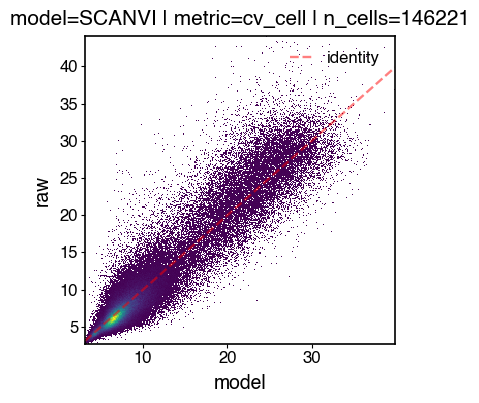

In [39]:
ppc_plt = PPCPlot(ppc)
ppc_plt.plot_cv(model_name="SCANVI", cell_wise=True, plt_type="hist2d")

fig_path = f'{temp_fig_dir}/ppc_cv_cell.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")

## 3️⃣ Goodness of fit with PPC + DE

In [28]:
# run ppc+DE
# estimated runtime: ~2min
ppc = run_ppc(adata, model, "diff_exp", n_samples = 1, de_groupby="scanvi_label", var_gene_names_col="feature_name")

In [51]:
ppc

--- Posterior Predictive Checks ---
n_samples = 1
raw_counts shape = (584884, 2000)
models: ['SCANVI']
metrics: 
{
    "diff_exp": {
        "adata_raw": "AnnData object with n_obs=584884, n_vars=2000",
        "var_names": {
            "AT1": [
                "HOPX",
                "EMP2"
            ],
            "AT2": [
                "SFTPB",
                "SFTPC"
            ],
            "Arterial EC": [
                "CLDN5",
                "IFITM3"
            ],
            "B cell lineage": [
                "CD79A",
                "IGKC"
            ],
            "Basal": [
                "KRT19",
                "S100A2"
            ],
            "Bronchial Vessel 1": [
                "SPARCL1",
                "GNG11"
            ],
            "Bronchial Vessel 2": [
                "IFI27",
                "IFITM3"
            ],
            "Capillary": [
                "CLDN5",
                "RAMP2"
            ],
            "Ciliated": [
         

Let's plot the LFC dotplots.

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub-clone/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


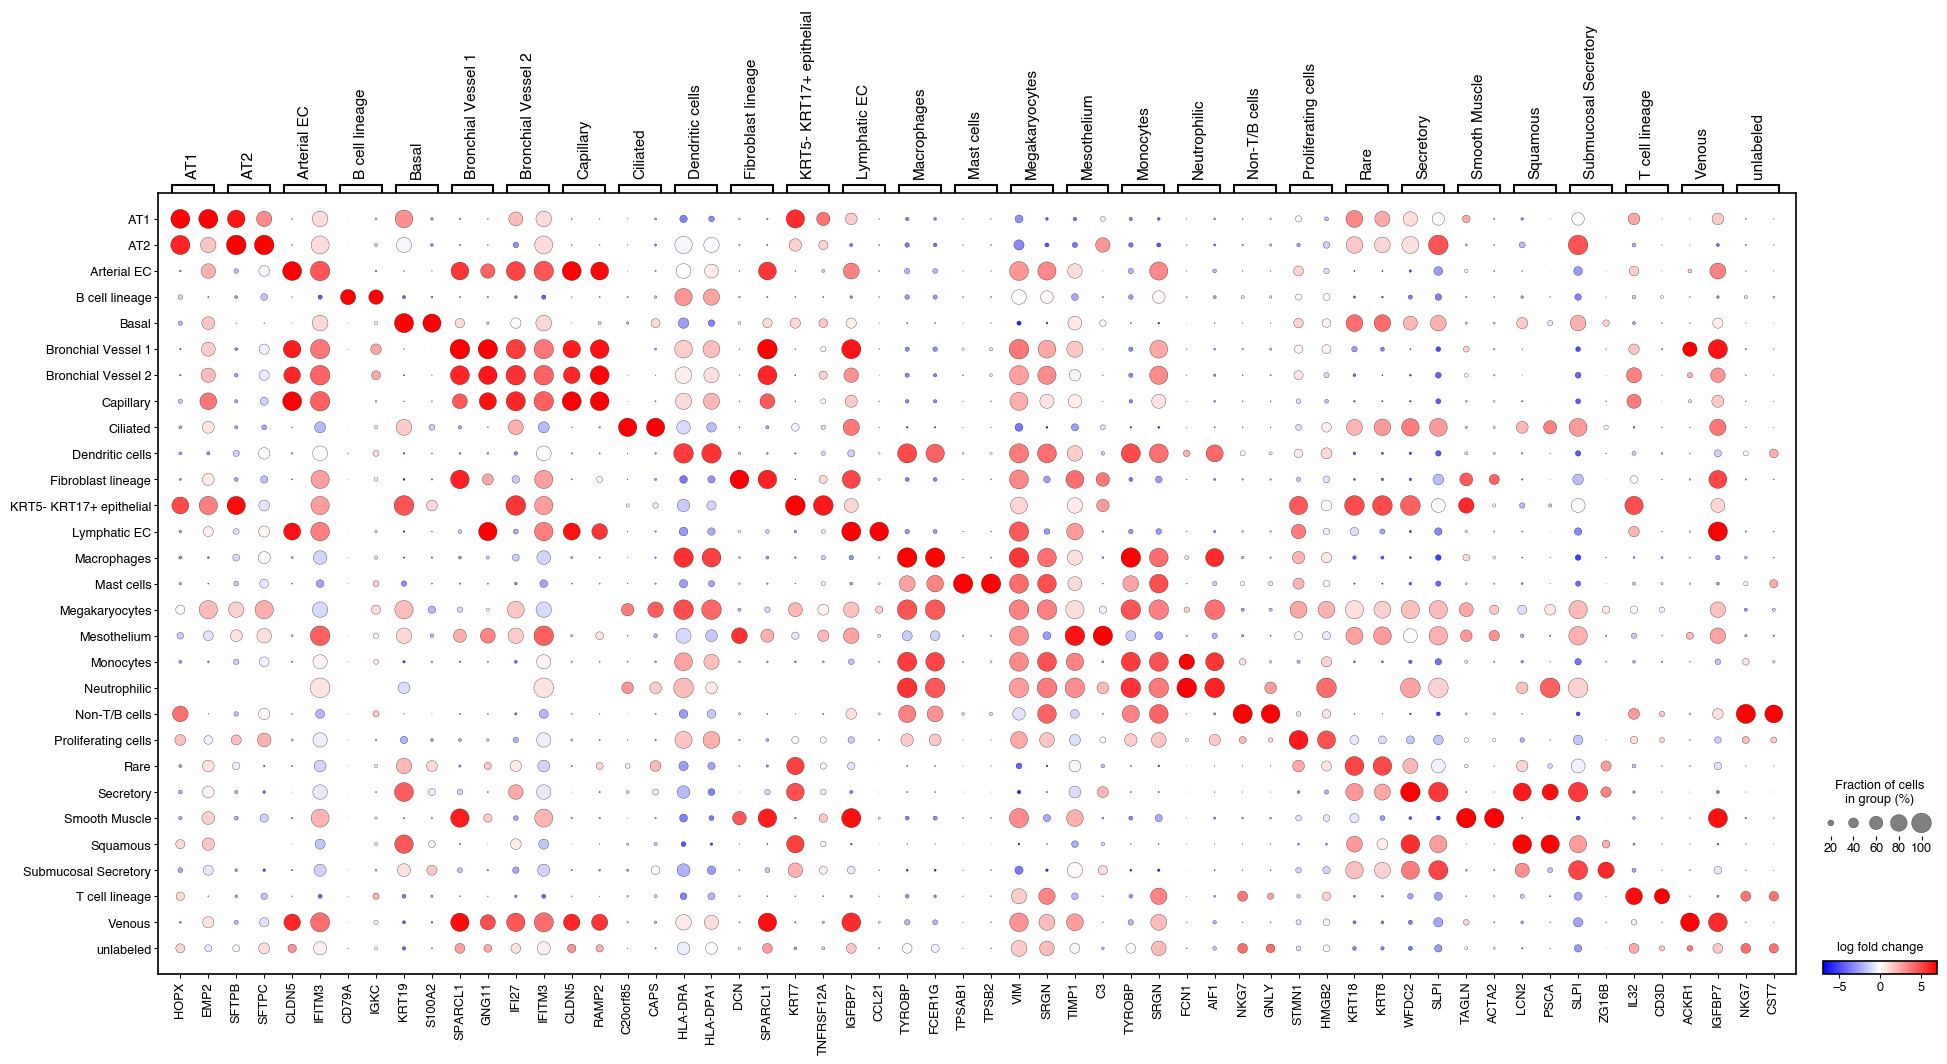

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub-clone/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


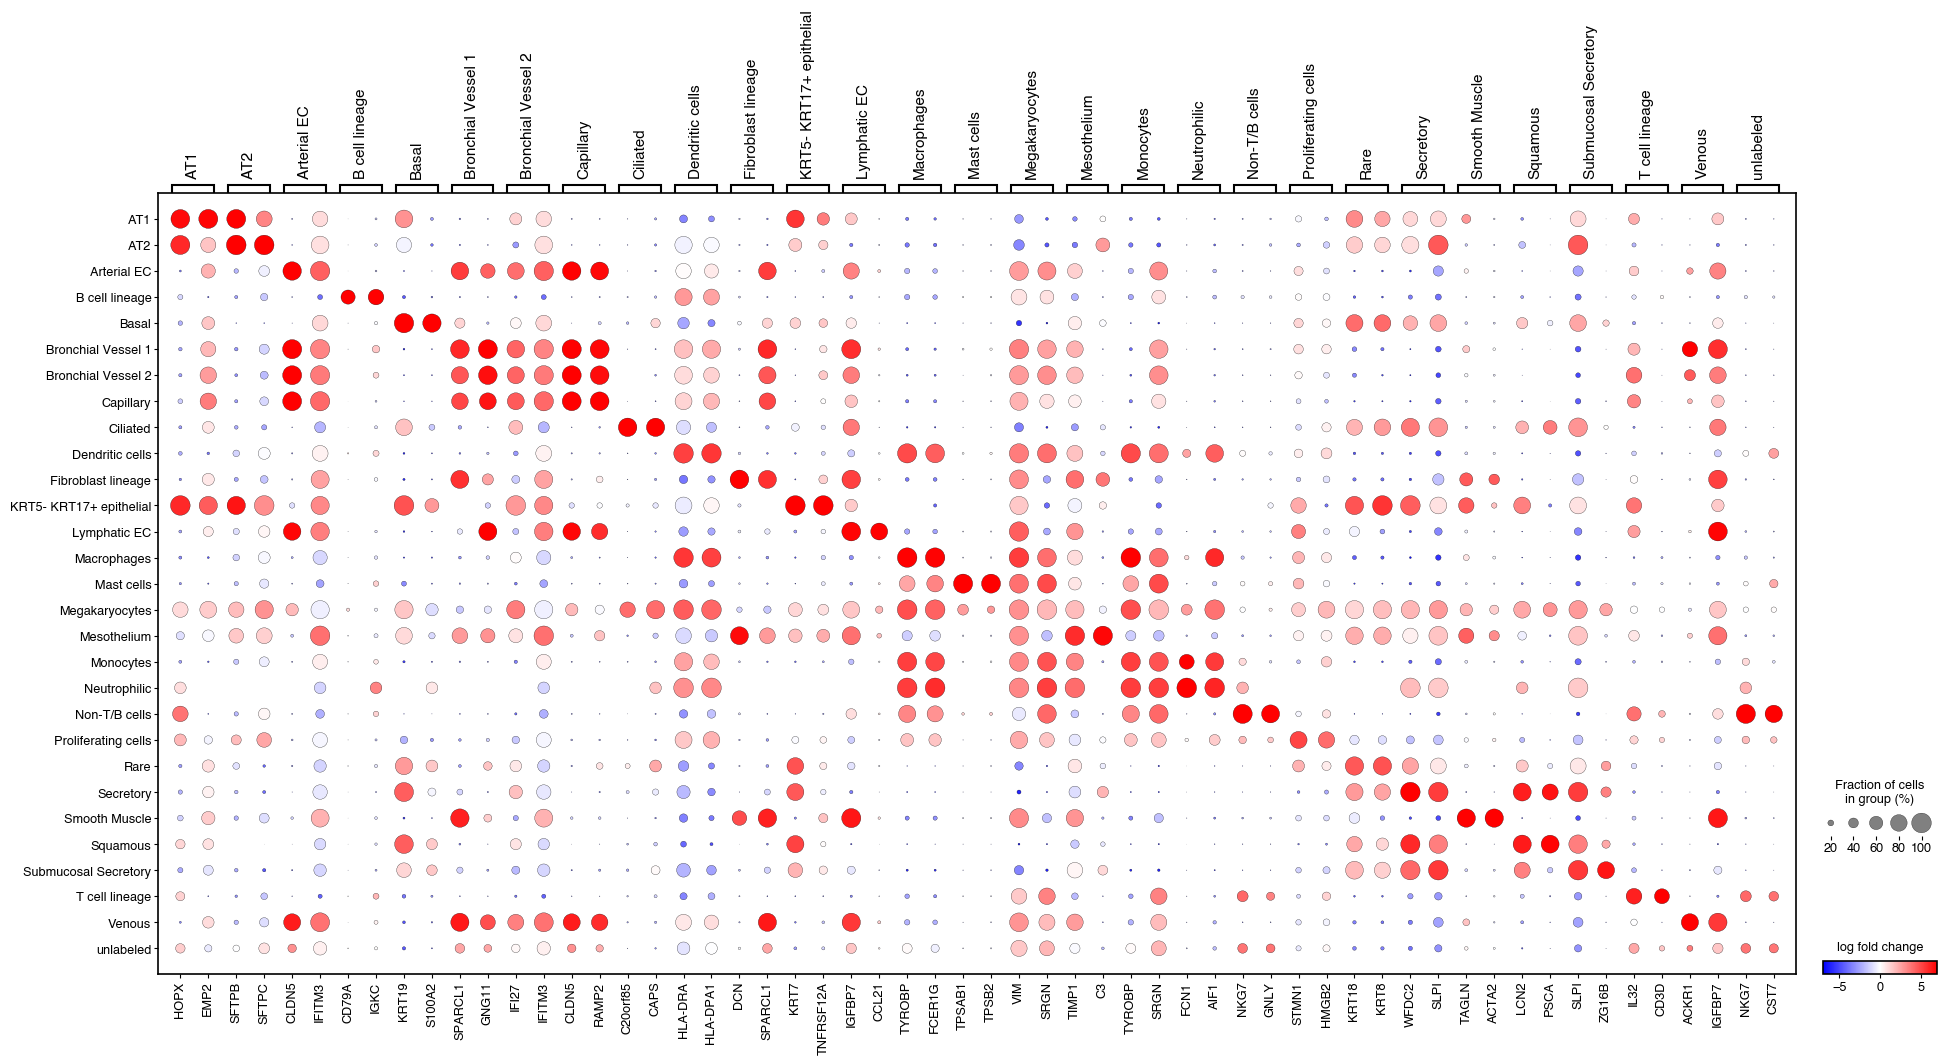

In [29]:
ppc_plt = PPCPlot(ppc)
dp_fig_1, dp_fig_2 = ppc_plt.plot_diff_exp("SCANVI", var_gene_names_col="feature_name", plot_kind="dotplots", save_fig=True)

In [32]:
# move the figs to another directory
dp_fig_1.replace(os.path.join(temp_fig_dir, dp_fig_1.name))
dp_fig_2.replace(os.path.join(temp_fig_dir, dp_fig_2.name))

PosixPath('/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/temp_figs/dotplot_approx.svg')

For better visualization let's plot smaller LFC dotplots, subsetted to immune cell types.

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub-clone/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


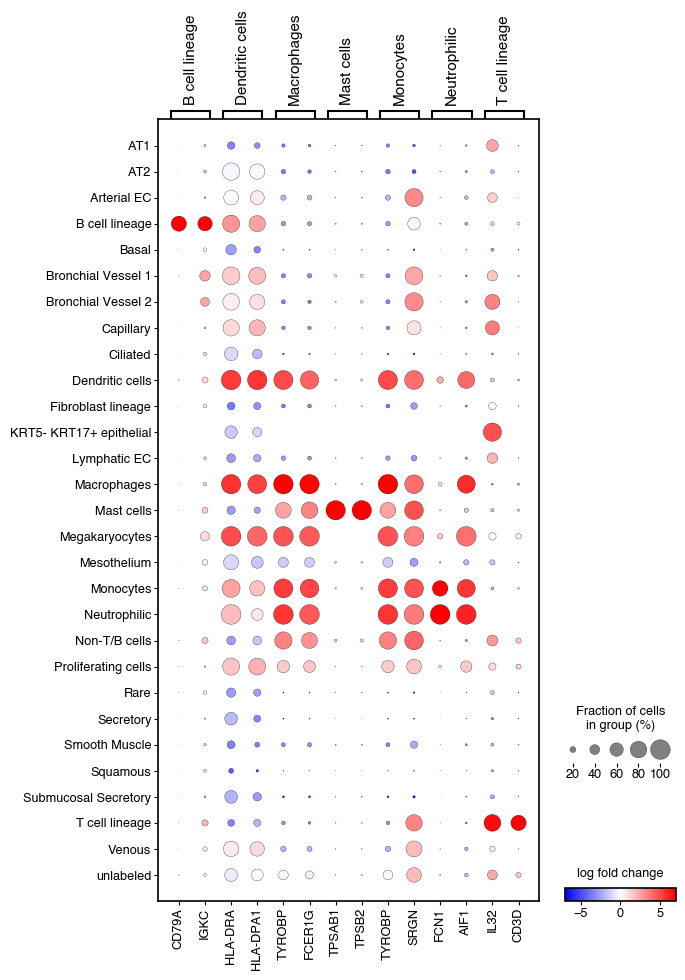

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub-clone/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


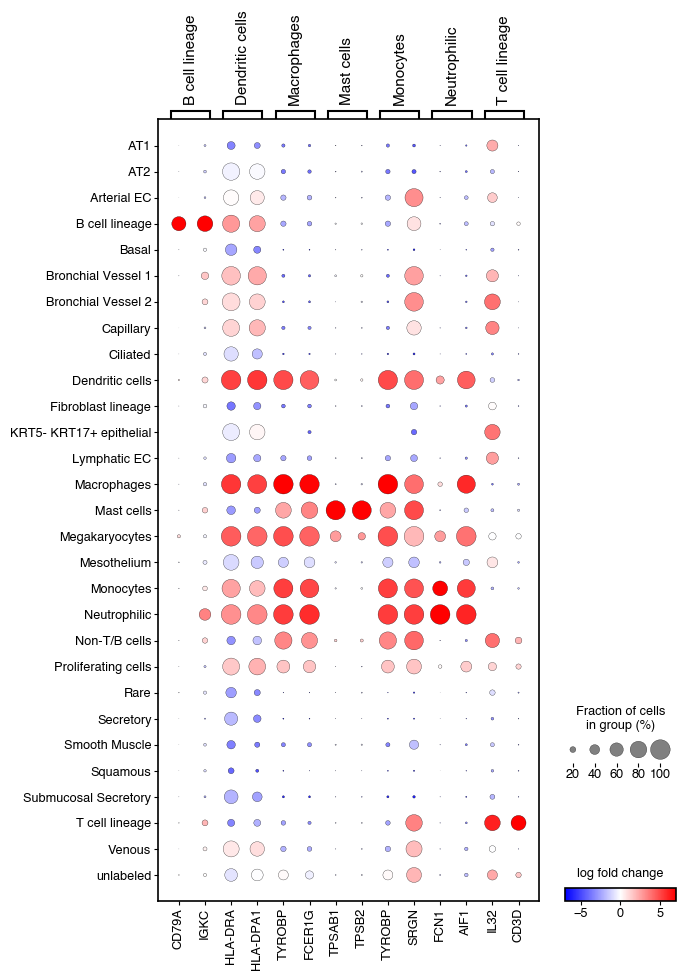

In [73]:
immune_types = [
    "B cell lineage",
    "Dendritic cells",
    "Macrophages",
    "Mast cells",
    "Monocytes",
    "Neutrophilic",
    "T cell lineage"
]

dp_fig_1, dp_fig_2 = ppc_plt.plot_diff_exp(
    "SCANVI",
    var_gene_names_col="feature_name",
    var_names_subset=immune_types,
    plot_kind="dotplots",
    save_fig=True
)

In [74]:
# move the figs to another directory
dp_fig_1.replace(os.path.join(temp_fig_dir, dp_fig_1.stem + "_subset" + dp_fig_1.suffix))
dp_fig_2.replace(os.path.join(temp_fig_dir, dp_fig_2.stem + "_subset" + dp_fig_2.suffix))

PosixPath('/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/temp_figs/dotplot_approx_subset.svg')

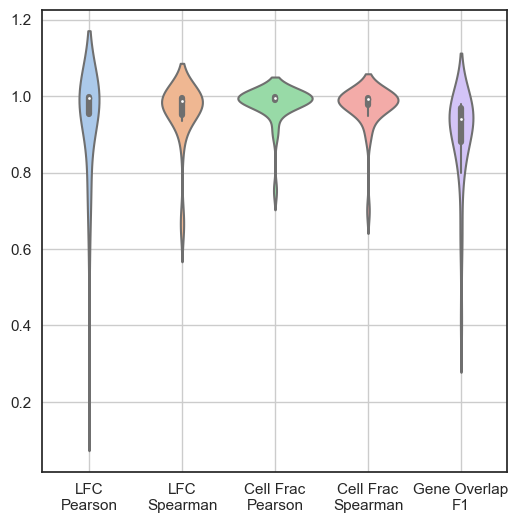

In [159]:
ppc_plt.plot_diff_exp(
    "SCANVI",
    var_gene_names_col="feature_name",
    plot_kind="summary_box",
)
fig_path = f'{temp_fig_dir}/de_summary_barplot.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

## 5️⃣ UMAP's

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub-clone/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


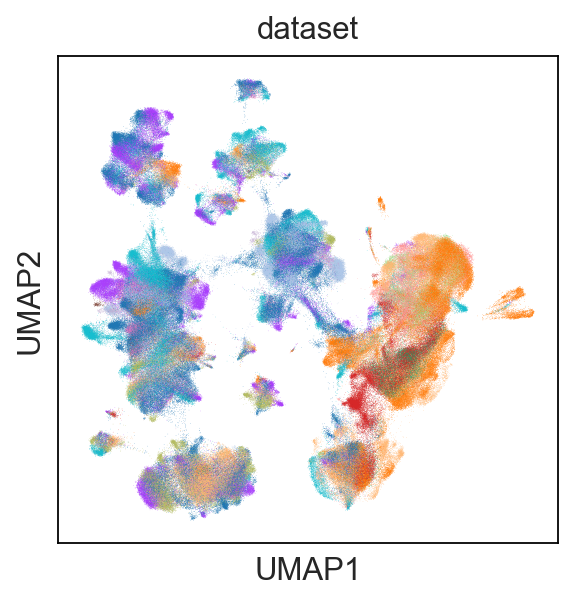

PosixPath('/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/temp_figs/umap_dataset.svg')

In [185]:
sc.set_figure_params(vector_friendly=True, dpi_save=300, fontsize=14)
# figsize: Optional[int] = None,
# color_map: Optional[str] = None,
sc.pl.umap(
    adata,
    color=["dataset"], # dataset is the batch key
    save="_dataset.svg",
    legend_loc="left margin", # "trick" to not show the legend
    # legend_fontsize = 10,
)

# move the fig to another directory
scanpy_fig_path = Path("figures/umap_dataset.svg").resolve()
scanpy_fig_path.replace(os.path.join(temp_fig_dir, "umap_dataset.svg"))

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub-clone/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


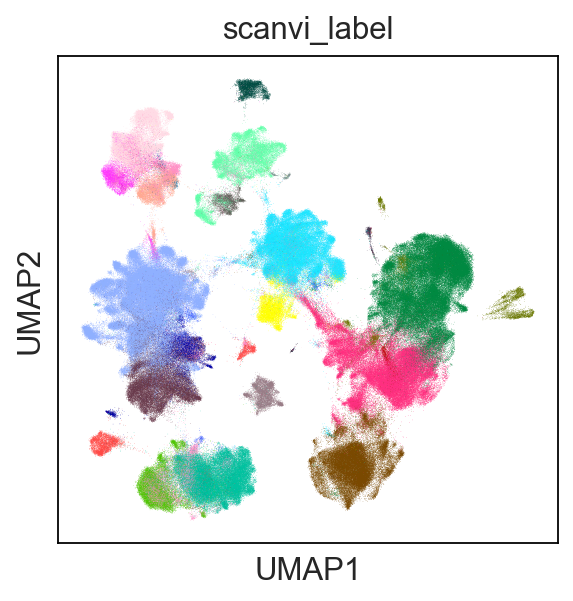

PosixPath('/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/temp_figs/umap_label.svg')

In [186]:
sc.set_figure_params(vector_friendly=True, dpi_save=300, fontsize=14)
sc.pl.umap(
    adata,
    color=["scanvi_label"],
    save="_label.svg",
    legend_loc="left margin", # "trick" to not show the legend
)

# move the fig to another directory
scanpy_fig_path = Path("figures/umap_label.svg").resolve()
scanpy_fig_path.replace(os.path.join(temp_fig_dir, "umap_label.svg"))

TODO plot predicted genes. adata.obs.cell_type.cat.categories

In [25]:
adata.obs.scanvi_label

GCGACCATCCCTAACC_SC22          Macrophages
P2_1_GCGCAACCAGTTAACC        Non-T/B cells
GCTCTGTAGTGCTGCC_SC27                  AT2
P2_8_TTAGGACGTTCAGGCC          Macrophages
CTTGATTGTCAGTTTG_T164                Basal
                                ...       
ACCTTTACATTAACCG_T120                Basal
CATTATCTCCATGAAC_F01639    Dendritic cells
AGGCCGTGTGTGACCC-SC56                  AT2
CGATGGCAGCAGGCTA-1-2             Secretory
AATCGGTGTCGGCACT-1-4             Secretory
Name: scanvi_label, Length: 584884, dtype: category
Categories (29, object): ['AT1', 'AT2', 'Arterial EC', 'B cell lineage', ..., 'Submucosal Secretory', 'T cell lineage', 'Venous', 'unlabeled']

In [27]:
adata.obs.cell_type.cat.categories

Index(['fibroblast', 'mesothelial cell', 'epithelial cell of lung', 'T cell',
       'mast cell', 'club cell', 'myofibroblast cell', 'smooth muscle cell',
       'B cell', 'serous secreting cell', 'mucus secreting cell',
       'dendritic cell', 'stromal cell', 'alveolar macrophage', 'acinar cell',
       'natural killer cell', 'CD4-positive, alpha-beta T cell',
       'CD8-positive, alpha-beta T cell', 'pericyte',
       'plasmacytoid dendritic cell', 'plasma cell', 'classical monocyte',
       'elicited macrophage', 'non-classical monocyte',
       'conventional dendritic cell', 'type I pneumocyte',
       'type II pneumocyte', 'brush cell of trachebronchial tree',
       'endothelial cell of lymphatic vessel',
       'ciliated columnar cell of tracheobronchial tree',
       'CD1c-positive myeloid dendritic cell', 'nasal mucosa goblet cell',
       'vein endothelial cell', 'fibroblast of lung', 'respiratory basal cell',
       'ionocyte', 'multi-ciliated epithelial cell',
       'tra

In [33]:
adata

AnnData object with n_obs × n_vars = 584884 × 2000
    obs: 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'sample', 'study', 'donor_id', 'smoking_status', 'BMI', 'condition', 'subject_type', 'sample_type', "3'_or_5'", 'sequencing_platform', 'cell_ranger_version', 'fresh_or_frozen', 'dataset', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_highest_res', 'n_genes', 'size_factors', 'log10_total_counts', 'mito_frac', 'ribo_frac', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'scanvi_label', 'leiden_1', 'leiden_2', 'leiden_3', 'anatomical_region_ccf_score', 'entropy_study_leiden_3', 'entropy_dataset_leiden_3', 'entropy